In [1]:
%matplotlib inline
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR3 as p
from linearmodels.asset_pricing import LinearFactorModel
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:158: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:42: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mea

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:273: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


In [7]:
sector_portfolio_sorts={}
amihud_values={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s],amihud_values[s]=quantile_portfolios_annual_with_rank(sector_zscores[s],cleansed,5)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:224: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:225: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


# Acharya and Pedersen (2005) pricing levels of liquidity and liquidity risk
$$E_t(r_{t+1}^i- r_f) =  \alpha + \kappa E_t(c_{t+1}^i) + \lambda_t(\beta_t + \beta_t^{L1} - \beta_t^{L2} - \beta_t^{L3}) $$
where

* $c_t$:  Liquidity cost 
* $\beta_t^{L1}$:  Commonality in liquidity with the market, $cov(c^i,c^M)$
* $\beta_t^{L2}$:  Return sensitivity to market liquidity, $cov(r^i,c^M)$
* $\beta_t^{L3}$:  Liquidity sensitivity to market returns, $cov(c^i,r^M)$


# Adding expected cost

In [9]:
final_res={}
for sec in ['Equities', 'Commodities', 'Fixed Income']:
    sector_res=pd.DataFrame()
    for bucket in ['0','1','2','3','4']:
        portfolio_rtn=sector_portfolio_sorts[sec][bucket]
        portfolio_amihud=amihud_values[sec][bucket]
        market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
        market_amihud=amihud[sector_zscores[sec].columns].median(axis=1)
        factor=pd.DataFrame()
        factor['Market']=market
        factor['E(c_t)']=portfolio_amihud
        factor['Factor1']=pd.rolling_corr(portfolio_amihud,market_amihud,12,min_periods=12)
        factor['Factor2']=pd.rolling_corr(portfolio_rtn,market_amihud,12,min_periods=12)
        factor['Factor3']=pd.rolling_corr(portfolio_amihud,market,12,min_periods=12)
        ind=portfolio_rtn['2001':].index
        #res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        res=sm.OLS(portfolio_rtn.loc[ind],factor.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        sector_res['Portfolio '+bucket]=res.params
        sector_res['Tstat'+bucket]=res.tvalues
    final_res[sec]=sector_res

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,min_periods=12).corr(other=<Series>)
  if sys.path[0] == '':
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,min_periods=12).corr(other=<Series>)
  del sys.path[0]
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,min_periods=12).corr(other=<Series>)
  


In [13]:
final_res.keys()

dict_keys(['Equities', 'Commodities', 'Fixed Income'])

In [12]:
for sec in final_res.keys():
    print(final_res[sec].round(2).T.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  Market &  E(c\_t) &  Factor1 &  Factor2 &  Factor3 \\
\midrule
Portfolio 0 &    0.92 &   -0.00 &    -0.01 &     0.01 &    -0.01 \\
Tstat0      &    9.88 &   -0.77 &    -1.14 &     0.46 &    -0.81 \\
Portfolio 1 &    0.82 &   -0.01 &    -0.00 &     0.00 &     0.01 \\
Tstat1      &   12.13 &   -2.95 &    -0.02 &     0.14 &     1.18 \\
Portfolio 2 &    1.04 &   -0.00 &    -0.00 &    -0.00 &     0.00 \\
Tstat2      &   34.59 &   -1.78 &    -0.51 &    -0.23 &     0.10 \\
Portfolio 3 &    0.86 &   -0.00 &     0.00 &    -0.00 &     0.01 \\
Tstat3      &   24.83 &   -1.69 &     0.74 &    -0.83 &     1.22 \\
Portfolio 4 &    0.95 &   -0.00 &     0.00 &    -0.00 &    -0.00 \\
Tstat4      &   30.94 &   -1.59 &     0.83 &    -0.21 &    -0.20 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
{} &  Market &  E(c\_t) &  Factor1 &  Factor2 &  Factor3 \\
\midrule
Portfolio 0 &    1.20 &    0.00 &     0.01 &     0.00 &     0.00 \\
Tstat0      &   23.72

# First diff changes to innovations of liquidity

Using a first difference approach instead of an AR(2) residual

In [58]:
sec='Commodities'
bucket='2'
portfolio_rtn=sector_portfolio_sorts[sec][bucket]
portoflio_amihud=amihud_values[sec][bucket].diff()
market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_amihud=amihud[sector_zscores[sec].columns].median(axis=1).diff()
factor=pd.DataFrame()
factor['Market']=market
factor['E(c_t)']=portfolio_amihud
factor['Factor1']=pd.rolling_corr(portfolio_amihud,market_amihud,24,min_periods=12)
factor['Factor2']=pd.rolling_corr(portfolio_rtn,market_amihud,24,min_periods=12)
factor['Factor3']=pd.rolling_corr(portfolio_amihud,market,24,min_periods=12)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=12).corr(other=<Series>)
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=12).corr(other=<Series>)
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.roll

                            OLS Regression Results                            
Dep. Variable:                      2   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     49.61
Date:                Sun, 25 Mar 2018   Prob (F-statistic):           1.79e-32
Time:                        06:39:26   Log-Likelihood:                 409.76
No. Observations:                 192   AIC:                            -807.5
Df Residuals:                     186   BIC:                            -788.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.003      2.003      0.0

# Changing to innovations of liquidity

Using AR(2) specification for calculating residuals

In [83]:
resid_df=calc_resd_df(amihud)

sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=resid_df[d_map[sect]].dropna(how='all')

In [84]:
sector_portfolio_sorts={}
amihud_values={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s],amihud_values[s]=quantile_portfolios_annual_with_rank(sector_zscores[s],cleansed,5)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:224: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model.py:225: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [85]:
final_res={}
for sec in ['Equities', 'Commodities', 'Fixed Income']:
    sector_res=pd.DataFrame()
    for bucket in ['0','1','2','3','4']:
        portfolio_rtn=sector_portfolio_sorts[sec][bucket]
        portoflio_amihud=amihud_values[sec][bucket]
        market=cleansed[sector_zscores[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
        market_amihud=amihud[sector_zscores[sec].columns].median(axis=1)
        factor=pd.DataFrame()
        factor['Market']=market
        factor['E(c_t)']=portfolio_amihud
        factor['Factor1']=pd.rolling_corr(portfolio_amihud,market_amihud,24,min_periods=12)
        factor['Factor2']=pd.rolling_corr(portfolio_rtn,market_amihud,24,min_periods=12)
        factor['Factor3']=pd.rolling_corr(portfolio_amihud,market,24,min_periods=12)
        ind=portfolio_rtn['2001':].index
        #res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        res=sm.OLS(portfolio_rtn.loc[ind],factor.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        #sector_res['Portfolio '+bucket]=res.params
        sector_res['Tstat'+bucket]=res.tvalues
    final_res[sec]=sector_res

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=12).corr(other=<Series>)
  if sys.path[0] == '':
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=12).corr(other=<Series>)
  del sys.path[0]
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,min_periods=12).corr(other=<Series>)
  


ValueError: On entry to DLASCL parameter number 5 had an illegal value

In [ ]:
final_res['Equities'].round(2)

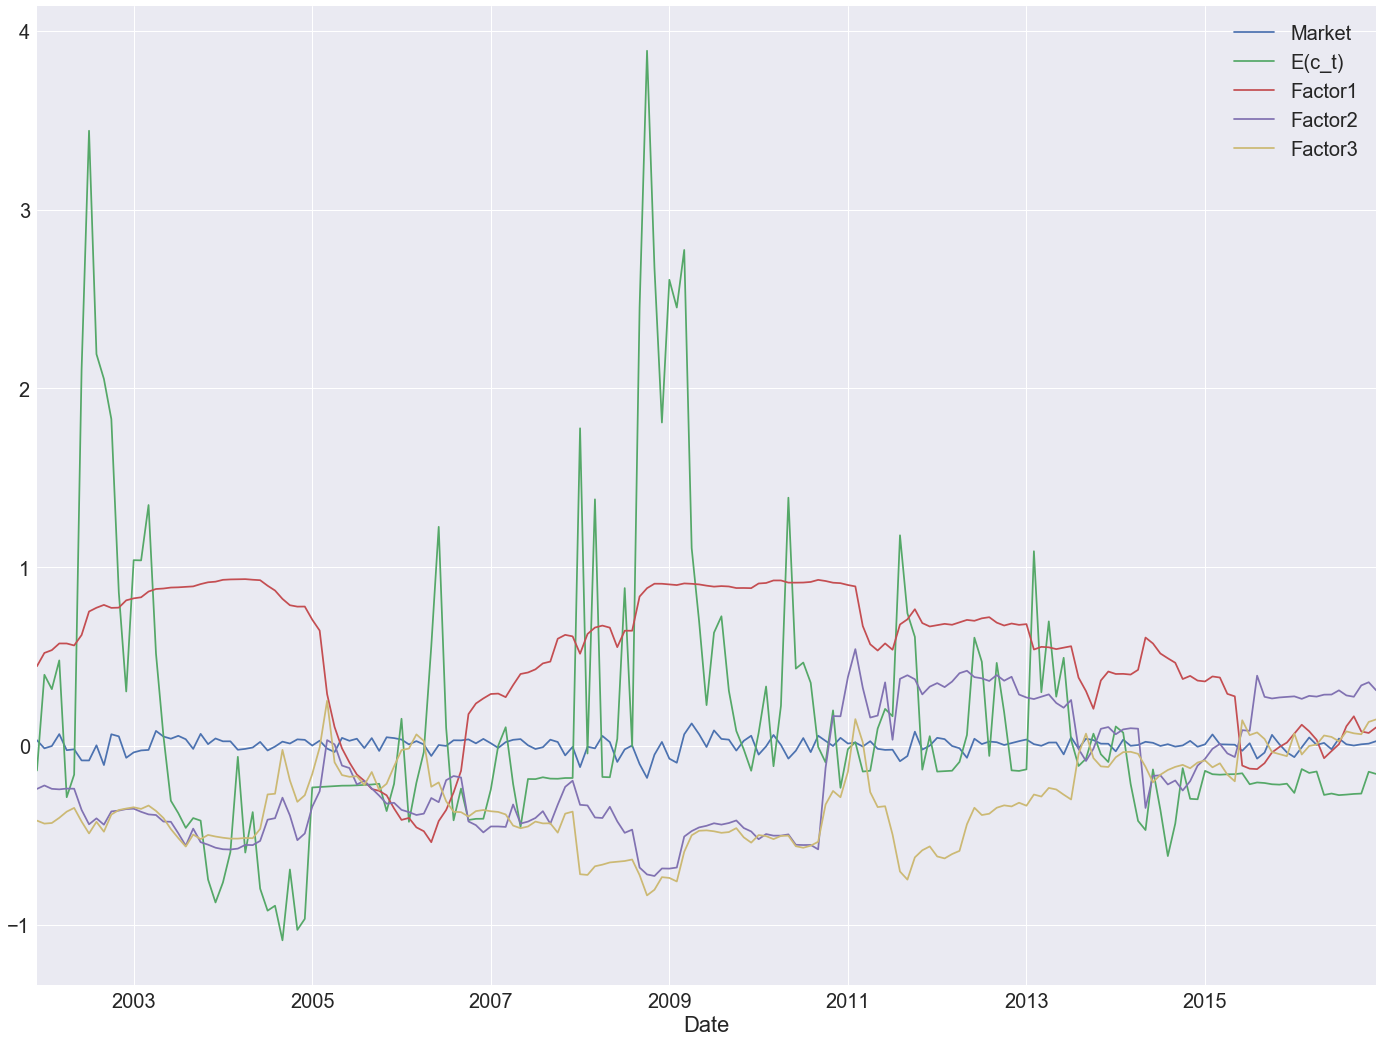

In [86]:
factor.dropna().plot()

In [354]:
number_of_buckets=5
deciles={}
med_value={}
for i in range(0,number_of_buckets,1):
    deciles[str(i)]=pd.Series()
    med_value[str(i)]=pd.Series()
for y in range(FHT.index[0].year,FHT.index[-1].year,1):
    year=str(y) + '-12-31'
    for i in range(0,number_of_buckets,1):
        mkts=quantile_columns(FHT.resample(rule='a',how='median'),year,number_of_buckets,i)
        rtns = cleansed.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)
        med=FHT[mkts][str(y+1)].median(axis=1)
        deciles[str(i)]=deciles[str(i)].append(rtns)
        med_value[str(i)]=med_value[str(i)].append(med)
    break
temp=pd.DataFrame(med_value)

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # This is added back by InteractiveShellApp.init_path()


In [355]:
med_value

{'0': 1992-01-31    0.002336
 1992-02-29    0.001809
 1992-03-31    0.003534
 1992-04-30    0.002384
 1992-05-31    0.002320
 1992-06-30    0.002061
 1992-07-31    0.001862
 1992-08-31    0.001897
 1992-09-30    0.004476
 1992-10-31    0.003529
 1992-11-30    0.002849
 1992-12-31    0.002795
 Freq: M, dtype: float64, '1': 1992-01-31    0.008390
 1992-02-29    0.008601
 1992-03-31    0.009319
 1992-04-30    0.007670
 1992-05-31    0.007710
 1992-06-30    0.008115
 1992-07-31    0.010698
 1992-08-31    0.013120
 1992-09-30    0.014020
 1992-10-31    0.009433
 1992-11-30    0.007492
 1992-12-31    0.007268
 dtype: float64, '2': 1992-01-31    0.012873
 1992-02-29    0.012594
 1992-03-31    0.011204
 1992-04-30    0.009342
 1992-05-31    0.013122
 1992-06-30    0.014767
 1992-07-31    0.016641
 1992-08-31    0.017762
 1992-09-30    0.018020
 1992-10-31    0.011976
 1992-11-30    0.010821
 1992-12-31    0.009852
 dtype: float64, '3': 1992-01-31    0.018235
 1992-02-29    0.016755
 1992-03-31

In [345]:
sector_portfolio_sorts['Equities'].count()

0    204
1    204
2    204
3    204
4    204
dtype: int64

In [343]:
cleansed.tail()

,CME-3 MTH EURODOLLAR COMP.,SFE-AUST 90 DAY BANK BILLS,EUREX-EURO SCHATZ,SFE-30 DAY INTERBANK CASH,TIFFE-3 MTH EUROYEN TIBOR,EUREX-EURO BOBL,TSE-10 YEAR T-BOND,CBT-10 YRS US T-NOTE COMP.,ME-BANK ACCEPT. 90 DAY,CBT-5 YEAR US T-NOTE COMP.,...,NORDPOOL-ENO,SAFEX-WHITE MAIZE,TOCOM-RUBBER,BMF-SOYBEAN,SHFE-GOLD,TGE-ROBUSTA COFFEE,TOCOM-SILVER,TOCOM-PALLADIUM,Rotterdam Coal,Milling Wheat
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-23,98.9500,98.20,112.200,98.500,NaN,133.30,150.25,124.8438,NaN,118.0469,...,29.00,3395.0,304.6,NaN,271.0,NaN,62.0,2788.0,89.30,239.0
2017-01-24,98.9475,98.20,112.175,98.500,NaN,133.11,150.39,124.2500,NaN,117.6953,...,29.55,3232.0,306.0,NaN,269.0,NaN,62.0,2825.0,89.20,238.0
2017-01-25,98.9450,98.22,112.130,98.505,NaN,132.78,150.08,123.8906,NaN,117.5313,...,28.93,3146.0,308.5,NaN,266.0,NaN,62.0,2889.0,88.85,236.0
2017-01-26,98.9450,98.22,112.135,98.505,NaN,132.76,149.84,123.9688,NaN,117.6016,...,29.00,3046.0,328.0,NaN,265.0,NaN,62.0,2697.0,88.50,237.0
2017-01-27,98.9500,98.22,112.145,NaN,NaN,132.75,150.00,124.1406,NaN,117.7031,...,28.60,NaN,347.0,NaN,NaN,NaN,62.0,2726.0,80.85,234.0


# FHT method

In [258]:
FHT=calculate_FHT(cleansed)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:53: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:54: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:55: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(

In [261]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores_FHT={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores_FHT[sect]=data[d_map[sect]].dropna(how='all')

sector_portfolio_sorts_FHT={}
FHT_values={}
for s in sector_zscores.keys():
    sector_portfolio_sorts_FHT[s],FHT_values[s]=quantile_portfolios_annual_with_rank(sector_zscores_FHT[s],cleansed,5)

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  # Remove the CWD from sys.path while we load stuff.
/Users/mrefermat/anaconda3/lib/python3.6/

In [264]:
sec='Equities'
bucket='4'
portfolio_rtn=sector_portfolio_sorts_FHT[sec][bucket]
# There is a problem with this line I assume its coming from the sorts as there is duplicate
# entries for each date
portfolio_FHT=FHT_values[sec][bucket]
market=cleansed[sector_zscores_FHT[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
market_FHT=FHT[sector_zscores_FHT[sec].columns].median(axis=1)
factor=pd.DataFrame()
factor['Market']=market
factor['Factor1']=pd.expanding_corr(portfolio_FHT,market_FHT)
factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_FHT)
factor['Factor3']=pd.expanding_corr(portfolio_FHT,market)
ind=portfolio_rtn['2001':].index
res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit()
print(res.summary())

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  if __name__ == '__main__':


ValueError: cannot reindex from a duplicate axis

In [276]:
market_FHT.count()

305

In [322]:
final_res_FHT={}
for sec in ['Equities', 'Commodities', 'Fixed Income']:
    sector_res=pd.DataFrame()
    for bucket in ['0','1','2','3','4']:
        portfolio_rtn=sector_portfolio_sorts_FHT[sec][bucket]
        portoflio_FHT=FHT_values[sec][bucket]
        market=cleansed[sector_zscores_FHT[sec].columns].resample(rule='m',how='last').pct_change().median(axis=1).dropna()
        market_FHT=FHT[sector_zscores_FHT[sec].columns].median(axis=1)
        factor=pd.DataFrame()
        factor['Market']=market
        factor['E(c_t)']=portfolio_amihud
        factor['Factor1']=pd.expanding_corr(portfolio_amihud,market_FHT)
        factor['Factor2']=pd.expanding_corr(portfolio_rtn,market_FHT)
        factor['Factor3']=pd.expanding_corr(portfolio_FHT,market)
        ind=portfolio_rtn['2001':].index
        res=sm.OLS(portfolio_rtn.loc[ind],sm.add_constant(factor.loc[ind])).fit(cov_type='HAC',cov_kwds={'maxlags':1})
        sector_res['Portfolio '+bucket]=res.params
        sector_res['Tstat'+bucket]=res.tvalues
    final_res_FHT[sec]=sector_res

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  if sys.path[0] == '':
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  del sys.path[0]
/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.expanding_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).corr(other=<Series>)
  


ValueError: cannot reindex from a duplicate axis

In [331]:
portfolio_FHT.count()

7773

In [332]:
market.count()

364

In [335]:
FHT_values['Equities'].count()

0    7266
1    7531
2    7828
3    7758
4    7773
dtype: int64